In [1]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
dj.config['database.host'] = 'datajoint.mesoscale-activity-map.org'
dj.config['database.user'] = 'pochen'
dj.config['database.password'] = 'simple'

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util

Connecting pochen@datajoint.mesoscale-activity-map.org:3306


# Plan
### Fetch population data
### Coding dimension analysis
### dsPCA




## Fetch population data

In [2]:
# after unit qc
foraging_session = experiment.Session & 'username = "hh"'
all_unit_qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat) & foraging_session & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70'
dj.U('annotation').aggr(((ephys.Unit & all_unit_qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:]

count
annotation                                              
Lateral septal nucleus, rostral (rostroventral)...   801
Caudoputamen                                         473
Secondary motor area, layer 6a                       401
Secondary motor area, layer 5                        294
Prelimbic area, layer 5                              286
...                                                  ...
Ethmoid nucleus of the thalamus                        1
Retrosplenial area, ventral part, layer 6a             1
Triangular nucleus of septum                           1
Prelimbic area, layer 6b                               1
Midbrain                                               1

[113 rows x 1 columns]

In [3]:
lab.WaterRestriction() & 'water_restriction_number LIKE "HH%"'

*subject_id    water_restrict cage_number    wr_start_date  wr_start_weigh
+------------+ +------------+ +------------+ +------------+ +------------+
472184         HH07           176952         2020-08-24     30.000        
472195         HH01           176954         2020-07-29     28.300        
473359         HH06           177549         2020-08-24     27.100        
473360         HH08           177549         2020-10-20     25.700        
473361         HH09           177549         2020-10-20     25.600        
473611         HH04           177643         2020-08-11     18.600        
482350         HH11           182525         2020-11-19     25.400        
482352         HH12           187449         2021-06-08     37.300        
482353         HH13           187450         2021-06-08     32.400        
482354         HH10           182526         2020-11-19     19.300        
490931         HH14           187214         2021-10-22     30.100        
490932         HH15           187214         2021-10-22     27.700        
   ...
 (Total: 15)

In [4]:
# select units
def select_unit_qc_region(all_unit_qc, region="Prelimbic%"):
    return (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "{}"'.format(region)


def unique_session_in_region(unit_qc_region, region):
    print('total number of units in the region {}: {}'.format(region, len(unit_qc_region)))
    print(' unique sessions: {}'.format(np.unique(unit_qc_region.fetch('session'))))
    session_unit_cts = {}
    for session in np.unique(unit_qc_region.fetch('session')):
        session_unit_cts[session] = np.sum(unit_qc_region.fetch('session')==session)
        print(' session {}: {}'.format(session, np.sum(unit_qc_region.fetch('session')==session)))
    return session_unit_cts


def select_unit_qc_region_mouse_session(all_unit_qc, region="Prelimbic%", mouse="HH09", session=47):
    unit_qc_region = select_unit_qc_region(all_unit_qc, region=region)
    return unit_qc_region & (lab.WaterRestriction & 'water_restriction_number = "{}"'.format(mouse)) & 'session = {}'.format(session)


# fetch keys
def gen_keys2units(unit_qc_region_mouse_session, check_laterality=True):
    
    # get all keys
    keys2units = unit_qc_region_mouse_session.fetch('KEY')
    print('num of units: {}'.format(len(keys2units)))

    # check the laterality of units
    if check_laterality:
        hemi = util._get_units_hemisphere(keys2units)
        print('laterality: {}'.format(hemi))

    return keys2units


def gen_keys2trials(keys2units):
    
    # fetch trials in the session
    # print(psth_foraging.TrialCondition().fetch('trial_condition_name'))
    # psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units
    keys2trials_all = (psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units).fetch('KEY')
    trials_all = psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units
    print('num of all trials: {}'.format(len(keys2trials_all)))

    keys2trials_L = (psth_foraging.TrialCondition().get_trials('foraging_L_all_noearlylick') & keys2units).fetch('KEY')
    trials_L = psth_foraging.TrialCondition().get_trials('foraging_L_all_noearlylick') & keys2units
    print('num of left trials: {}'.format(len(keys2trials_L)))

    keys2trials_R = (psth_foraging.TrialCondition().get_trials('foraging_R_all_noearlylick') & keys2units).fetch('KEY')
    trials_R = psth_foraging.TrialCondition().get_trials('foraging_R_all_noearlylick') & keys2units
    print('num of right trials: {}'.format(len(keys2trials_R)))

    keys2trials_hit = (psth_foraging.TrialCondition().get_trials('foraging_LR_hit_noearlylick') & keys2units).fetch('KEY')
    trials_hit = psth_foraging.TrialCondition().get_trials('foraging_LR_hit_noearlylick') & keys2units
    print('num of hit trials: {}'.format(len(keys2trials_hit)))

    keys2trials_miss = (psth_foraging.TrialCondition().get_trials('foraging_LR_miss_noearlylick') & keys2units).fetch('KEY')
    trials_miss = psth_foraging.TrialCondition().get_trials('foraging_LR_miss_noearlylick') & keys2units
    print('num of miss trials: {}'.format(len(keys2trials_miss)))

    return [keys2trials_all, keys2trials_L, keys2trials_R, keys2trials_hit, keys2trials_miss], [trials_all, trials_L, trials_R, trials_hit, trials_miss]


# generate psth per trial
def gen_psth_per_trial(keys2units, trials, align_type='iti_start'):
    
    pop_psth_per_trial = []
    trial_ind = []
    bins = None
    for key in keys2units:
        unit_psth_raster = psth_foraging.compute_unit_psth_and_raster(key, trials, align_type)
        unit_psth_per_trial = unit_psth_raster['psth_per_trial']  # (trial, time_step)
        pop_psth_per_trial.append(unit_psth_per_trial)
        if bins is None:
            bins = unit_psth_raster['bins']
    pop_psth_per_trial = np.array(pop_psth_per_trial)
    pop_psth_per_trial = np.moveaxis(pop_psth_per_trial, 1, -1)
    print('bins: {}'.format(bins.shape))
    print('population psth per trial: {}'.format(pop_psth_per_trial.shape))

    return bins, pop_psth_per_trial


def get_psth_by_trial_type_index(pop_psth, all_trial_ind, select_trial_ind):
    
    select_index = np.where(np.in1d(all_trial_ind, select_trial_ind))[0]
    pop_psth_selected_trial = pop_psth[:, :, select_index]
    print('check: sel trial ind {}, output pop psth {}'.format(select_trial_ind.shape, pop_psth_selected_trial.shape))
    
    return pop_psth_selected_trial

In [5]:
# fetch data from brain region

# prelimbic: 
region, mouse, session = "Prelimbic%", "HH09", 47
# Lateral septal nucleus, rostral (rostroventral) part
# region, mouse, session ="Lateral septal nucleus, rostral (rostroventral) part", "HH08", 49
# Secondary motor area, layer 6a
# region, mouse, session ="Secondary motor area, layer 6a", "HH09", 50
# Caudoputamen
# region, mouse, session ="Caudoputamen", "HH13", 45

# select qc unit in region
# region = "Caudoputamen"
unit_qc_region = select_unit_qc_region(all_unit_qc, region=region)
session_unit_cts = unique_session_in_region(unit_qc_region, region=region)

# select qc in region, by mouse and session
# region = "Caudoputamen"
# session = 45
# subject_id = np.unique((unit_qc_region & 'session={}'.format(session)).fetch('subject_id'))
# if len(subject_id) == 1:
#     mouse = (lab.WaterRestriction() & 'subject_id={}'.format(subject_id[0])).fetch('water_restriction_number')[0]
#     print('mouse: {}'.format(mouse))

unit_qc_region_mouse_session = select_unit_qc_region_mouse_session(all_unit_qc, region=region, mouse=mouse, session=session)
print('total number of units in {} by mouse {} by session {}: {}'.format(region, mouse, session, len(unit_qc_region_mouse_session)))


# fetch keys
keys2units = gen_keys2units(unit_qc_region_mouse_session, check_laterality=True)
# keys2units = gen_keys2units(unit_qc_region_mouse_session, check_laterality=False)
[keys2trials_all, keys2trials_L, keys2trials_R, keys2trials_hit, keys2trials_miss], [trials_all, trials_L, trials_R, trials_hit, trials_miss] = gen_keys2trials(keys2units)


total number of units in the region Prelimbic%: 409
 unique sessions: [34 36 37 46 47 48 49 50 51 52]
 session 34: 17
 session 36: 19
 session 37: 3
 session 46: 46
 session 47: 58
 session 48: 45
 session 49: 76
 session 50: 48
 session 51: 4
 session 52: 93
total number of units in Prelimbic% by mouse HH09 by session 47: 58
num of units: 58
laterality: right
num of all trials: 408
num of left trials: 233
num of right trials: 175
num of hit trials: 135
num of miss trials: 273


In [6]:
bins, pop_psth_all = gen_psth_per_trial(keys2units, trials_all, align_type='iti_start')  
# pop_psth_all: (unit, time_step, trial)

all_trial_ind = np.array(trials_all.fetch('trial'))
left_trial_ind = np.array((trials_all & 'water_port="left"').fetch('trial'))
right_trial_ind = np.array((trials_all & 'water_port="right"').fetch('trial'))
hit_trial_ind = np.array((trials_all & 'outcome="hit"').fetch('trial'))
miss_trial_ind = np.array((trials_all & 'outcome="miss"').fetch('trial'))


pop_psth_L = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, left_trial_ind)
pop_psth_R = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, right_trial_ind)

pop_psth_hit = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, hit_trial_ind)
pop_psth_miss = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, miss_trial_ind)

bins: (324,)
population psth per trial: (58, 324, 408)
check: sel trial ind (233,), output pop psth (58, 324, 233)
check: sel trial ind (175,), output pop psth (58, 324, 175)
check: sel trial ind (135,), output pop psth (58, 324, 135)
check: sel trial ind (273,), output pop psth (58, 324, 273)


## Coding Axes

L trials psth shape: (58, 324, 233)
 selected dir trials: (116,)
 selected proj trials: (117,)
R trials psth shape: (58, 324, 175)
 selected dir trials: (87,)
 selected proj trials: (88,)
 check raw coding direction norm: 23.01291735473396
 check normalized coding direction norm: 0.9999999999999999


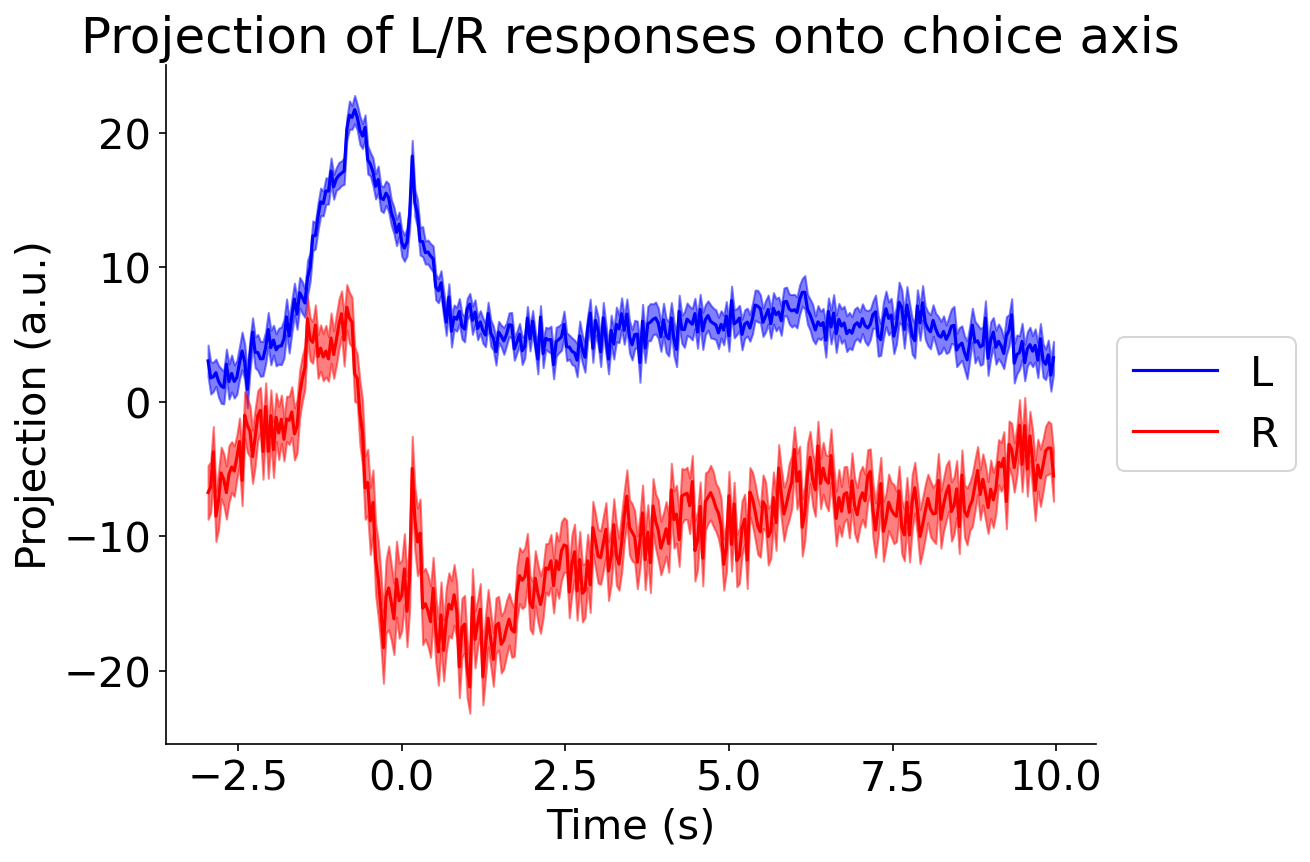

hit trials psth shape: (58, 324, 135)
 selected dir trials: (67,)
 selected proj trials: (68,)
miss trials psth shape: (58, 324, 273)
 selected dir trials: (136,)
 selected proj trials: (137,)
 check raw coding direction norm: 16.241151737463717
 check normalized coding direction norm: 0.9999999999999999


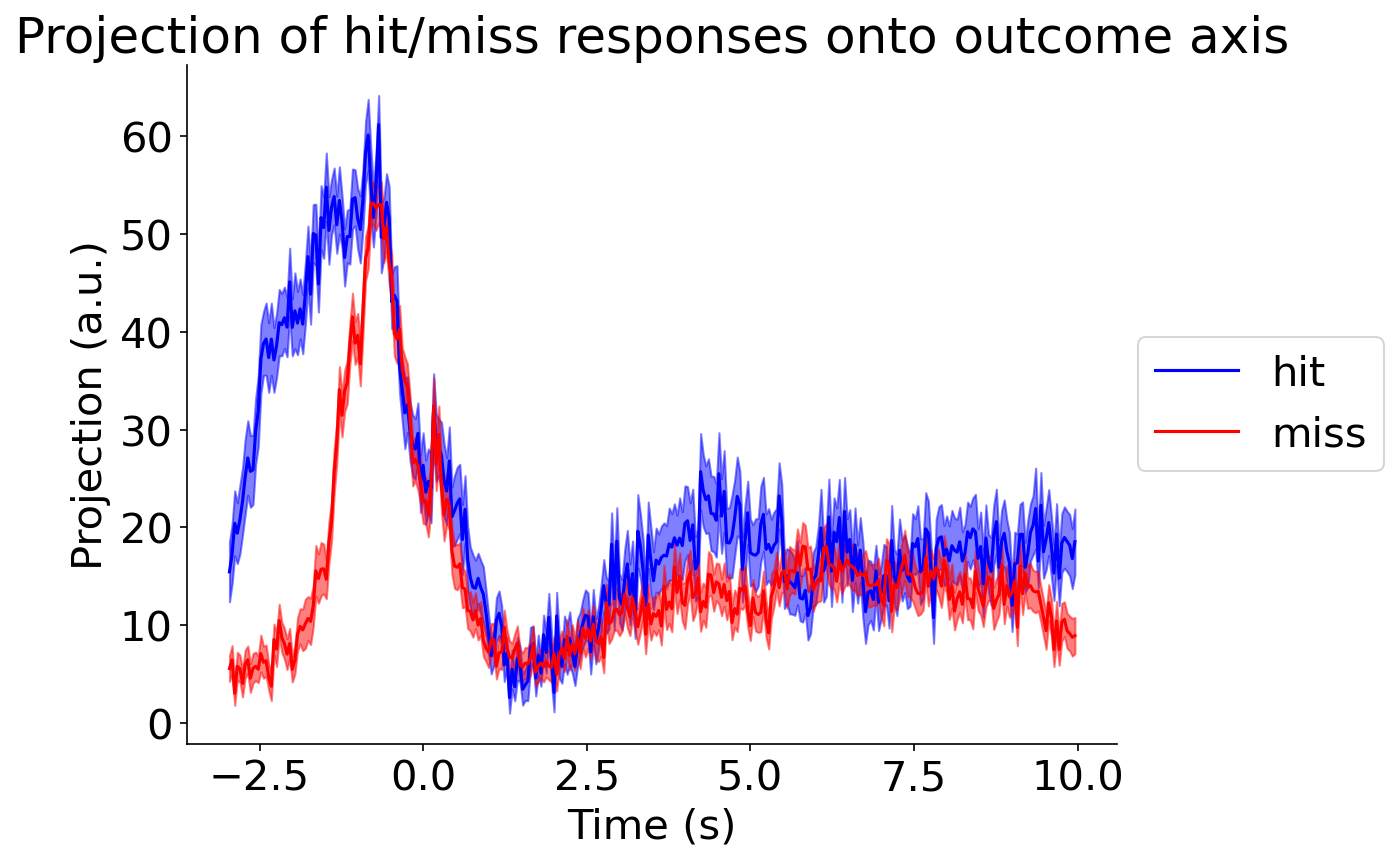

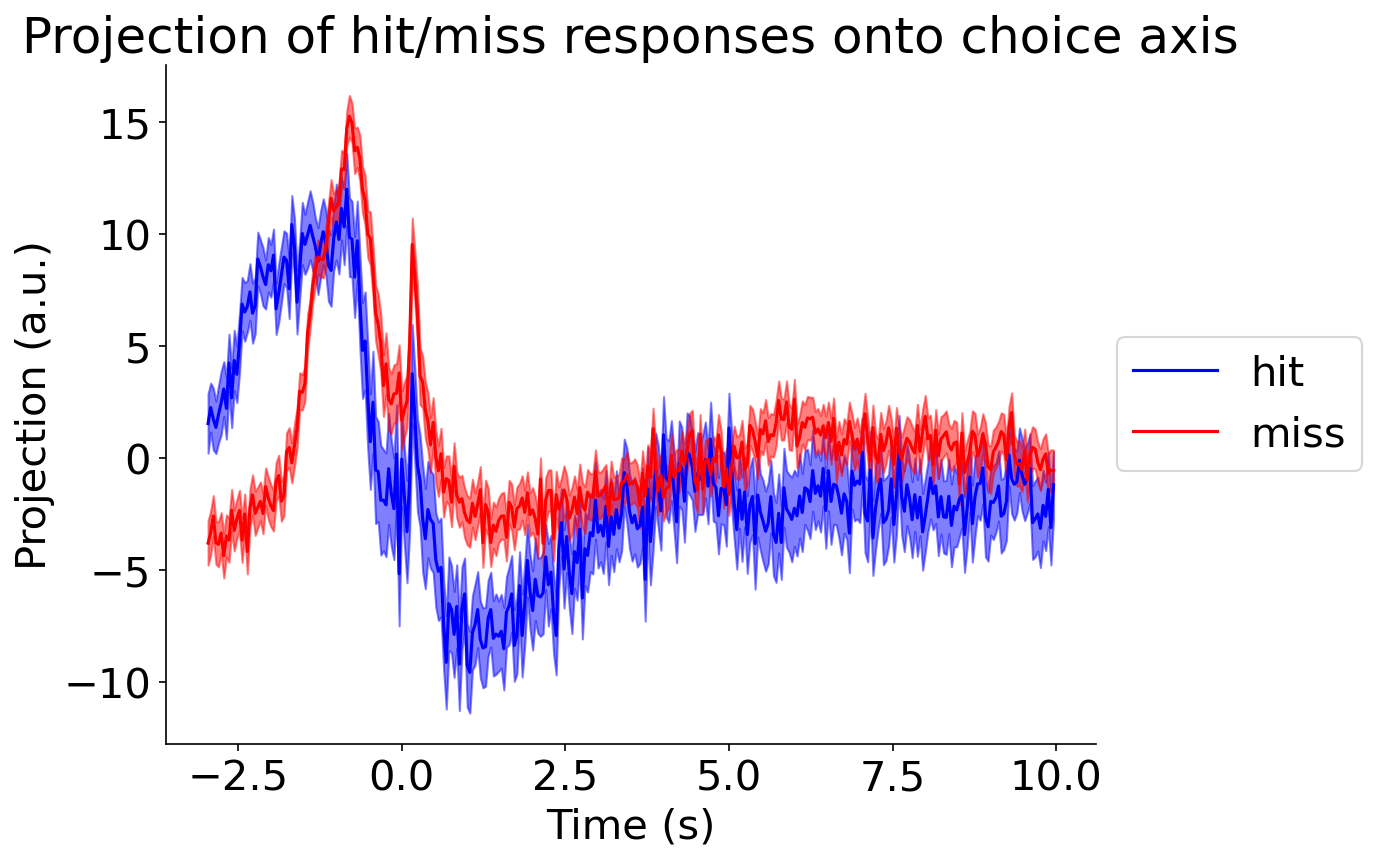

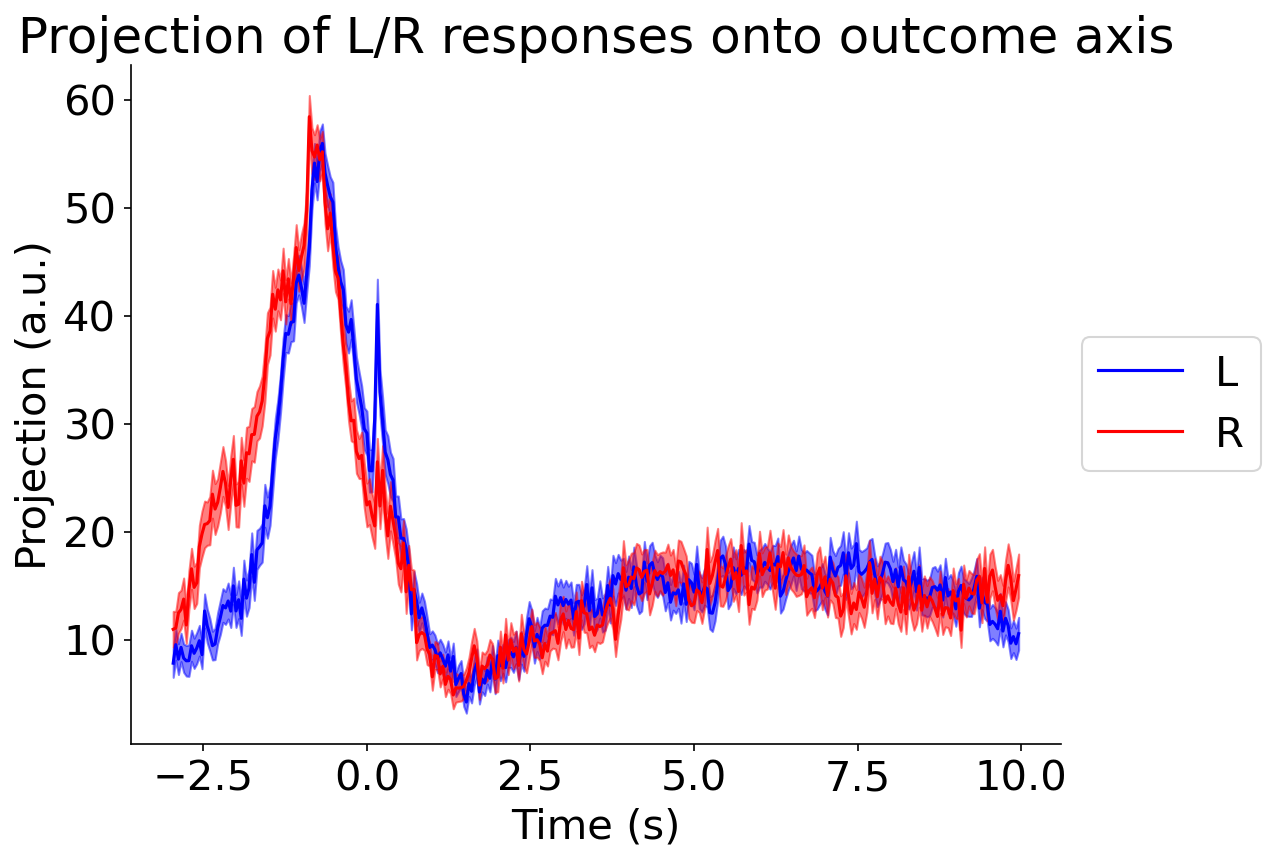

In [7]:
import random

SEED = 10
random.seed(SEED)

def split_index_for_direction_projection(num_trial):
    
    ind_direction = np.random.choice(np.arange(num_trial), int(num_trial/2), replace=False)
    ind_empty = np.zeros(num_trial, dtype=bool)
    ind_empty[ind_direction] = True
    ind_projection = np.where(~ind_empty)[0]

    return ind_direction, ind_projection


def get_coding_direction(pop_psth_1, pop_psth_2, time, time_window):
    '''
    pop_psth_1: (unit, timebin, trial)
    pop_psth_2: (unit, timebin, trial)
    time: (timebin)
    time_window: tuple (time_start, time_end)
    '''
    # average over trials
    pop_psth_1_trial_avg = np.average(pop_psth_1, axis=2)  
    pop_psth_2_trial_avg = np.average(pop_psth_2, axis=2)
    
    # population selectivity vector
    pop_selectivity_vector = pop_psth_1_trial_avg - pop_psth_2_trial_avg  # (unit, timebin)
    coding_window_index = np.where((time>=time_window[0]) & (time<time_window[1]))[0]
    pop_selectivity_vector_time_avg = np.average(pop_selectivity_vector[:, coding_window_index], axis=1)
    print(' check raw coding direction norm: {}'.format(np.linalg.norm(pop_selectivity_vector_time_avg)))
    pop_selectivity_unit_vector = pop_selectivity_vector_time_avg/ np.linalg.norm(pop_selectivity_vector_time_avg)
    print(' check normalized coding direction norm: {}'.format(np.linalg.norm(pop_selectivity_unit_vector)))
    return pop_selectivity_unit_vector


def get_coding_direction_projection(pop_psth, coding_dir):
    '''
    pop_psth: (unit, timebin, trial)
    time: (timebin)
    time_window: tuple (time_start, time_end)
    '''
    proj = np.inner(np.moveaxis(pop_psth, 0, -1), coding_dir) # (timebin, trial)
    proj_trial_avg = np.average(proj, axis=1)
    proj_trial_std = np.std(proj, axis=1)
    proj_trial_sem = proj_trial_std / np.sqrt(proj.shape[1])

    return proj_trial_avg, proj_trial_sem
    

def plot_projection_coding_axis(proj_1, proj_1_sem, proj_2, proj_2_sem, bins,
                                proj_1_source_name, proj_2_source_name, axis_name):
    fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
    plt.plot(bins, proj_1, 'b-', label=proj_1_source_name)
    plt.fill_between(bins, proj_1-proj_1_sem, proj_1+proj_1_sem,
                    alpha=0.5, color='b')
    plt.plot(bins, proj_2, 'r-', label=proj_2_source_name)
    plt.fill_between(bins, proj_2-proj_2_sem, proj_2+proj_2_sem,
                    alpha=0.5, color='r')
    plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
    plt.xlabel('Time (s)')
    plt.ylabel('Projection (a.u.)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    plt.show()


L_ind_dir, L_ind_proj = split_index_for_direction_projection(pop_psth_L.shape[2])
print('L trials psth shape: {}'.format(pop_psth_L.shape))
print(' selected dir trials: {}'.format(L_ind_dir.shape))
print(' selected proj trials: {}'.format(L_ind_proj.shape))
R_ind_dir, R_ind_proj = split_index_for_direction_projection(pop_psth_R.shape[2])
print('R trials psth shape: {}'.format(pop_psth_R.shape))
print(' selected dir trials: {}'.format(R_ind_dir.shape))
print(' selected proj trials: {}'.format(R_ind_proj.shape))
choice_coding_dir = get_coding_direction(pop_psth_L[:, :, L_ind_dir], pop_psth_R[:, :, R_ind_dir], bins, (0, 2.5))
L_proj_choice_dir, L_proj_choice_dir_sem = get_coding_direction_projection(pop_psth_L[:, :, L_ind_proj], choice_coding_dir)
R_proj_choice_dir, R_proj_choice_dir_sem = get_coding_direction_projection(pop_psth_R[: ,:, R_ind_proj], choice_coding_dir)
plot_projection_coding_axis(L_proj_choice_dir, L_proj_choice_dir_sem, R_proj_choice_dir, R_proj_choice_dir_sem, bins,
                            'L', 'R', 'choice')

hit_ind_dir, hit_ind_proj = split_index_for_direction_projection(pop_psth_hit.shape[2])
print('hit trials psth shape: {}'.format(pop_psth_hit.shape))
print(' selected dir trials: {}'.format(hit_ind_dir.shape))
print(' selected proj trials: {}'.format(hit_ind_proj.shape))
miss_ind_dir, miss_ind_proj = split_index_for_direction_projection(pop_psth_miss.shape[2])
print('miss trials psth shape: {}'.format(pop_psth_miss.shape))
print(' selected dir trials: {}'.format(miss_ind_dir.shape))
print(' selected proj trials: {}'.format(miss_ind_proj.shape))
outcome_coding_dir = get_coding_direction(pop_psth_hit[:, :, hit_ind_dir], pop_psth_miss[:, :, miss_ind_dir], bins, (-2.5, 0))
hit_proj_outcome_dir, hit_proj_outcome_dir_sem = get_coding_direction_projection(pop_psth_hit[:, :, hit_ind_proj], outcome_coding_dir)
miss_proj_outcome_dir, miss_proj_outcome_dir_sem = get_coding_direction_projection(pop_psth_miss[:, :, miss_ind_proj], outcome_coding_dir)
plot_projection_coding_axis(hit_proj_outcome_dir, hit_proj_outcome_dir_sem, miss_proj_outcome_dir, miss_proj_outcome_dir_sem, bins,
                            'hit', 'miss', 'outcome')

hit_proj_choice_dir, hit_proj_choice_dir_sem = get_coding_direction_projection(pop_psth_hit, choice_coding_dir)
miss_proj_choice_dir, miss_proj_choice_dir_sem = get_coding_direction_projection(pop_psth_miss, choice_coding_dir)
plot_projection_coding_axis(hit_proj_choice_dir, hit_proj_choice_dir_sem, miss_proj_choice_dir, miss_proj_choice_dir_sem, bins,
                            'hit', 'miss', 'choice')

L_proj_outcome_dir, L_proj_outcome_dir_sem = get_coding_direction_projection(pop_psth_L, outcome_coding_dir)
R_proj_outcome_dir, R_proj_outcome_dir_sem = get_coding_direction_projection(pop_psth_R, outcome_coding_dir)
plot_projection_coding_axis(L_proj_outcome_dir, L_proj_outcome_dir_sem, R_proj_outcome_dir, R_proj_outcome_dir_sem, bins,
                            'L', 'R', 'outcome')

In [11]:
int(324/12)

27

In [23]:
# coding direction evolution analysis
def coding_direction_evolution(pop_psth_1, pop_psth_2, window=20):
    '''
    pop_psth_1: (unit, timebin, trial)
    pop_psth_2: (unit, timebin, trial)
    time: (timebin)
    time_window: tuple (time_start, time_end)
    '''
    # average over trials
    pop_psth_1_trial_avg = np.average(pop_psth_1, axis=2)  
    pop_psth_2_trial_avg = np.average(pop_psth_2, axis=2)
    
    # population selectivity vector
    pop_selectivity_vector = pop_psth_1_trial_avg - pop_psth_2_trial_avg  # (unit, timebin)
    pop_sel_vector_t = []
    for t in range(int(pop_selectivity_vector.shape[1]/window)):
        pop_selectivity_vector_time_avg_t = np.average(pop_selectivity_vector[:, window*t: min(window*(t+1), pop_selectivity_vector.shape[1])], axis=1)
        # normalization
        pop_selectivity_vector_time_avg_t = pop_selectivity_vector_time_avg_t/ np.linalg.norm(pop_selectivity_vector_time_avg_t)
        pop_sel_vector_t.append(pop_selectivity_vector_time_avg_t)
    pop_sel_vector_t = np.array(pop_sel_vector_t)
    print(pop_sel_vector_t.shape)

    dot_product_matrix = []
    for i in range(pop_sel_vector_t.shape[0]):
        dot_product_row = []
        for j in range(pop_sel_vector_t.shape[0]):
            dot_product_row.append(np.inner(pop_sel_vector_t[i,:], pop_sel_vector_t[j,:]))
        dot_product_matrix.append(dot_product_row)
    dot_product_matrix = np.array(dot_product_matrix)
    print(dot_product_matrix.shape)

    return dot_product_matrix


evol_confusion_matrix = coding_direction_evolution(pop_psth_L[:, :, L_ind_dir], pop_psth_R[:, :, R_ind_dir])

(16, 58)
(16, 16)


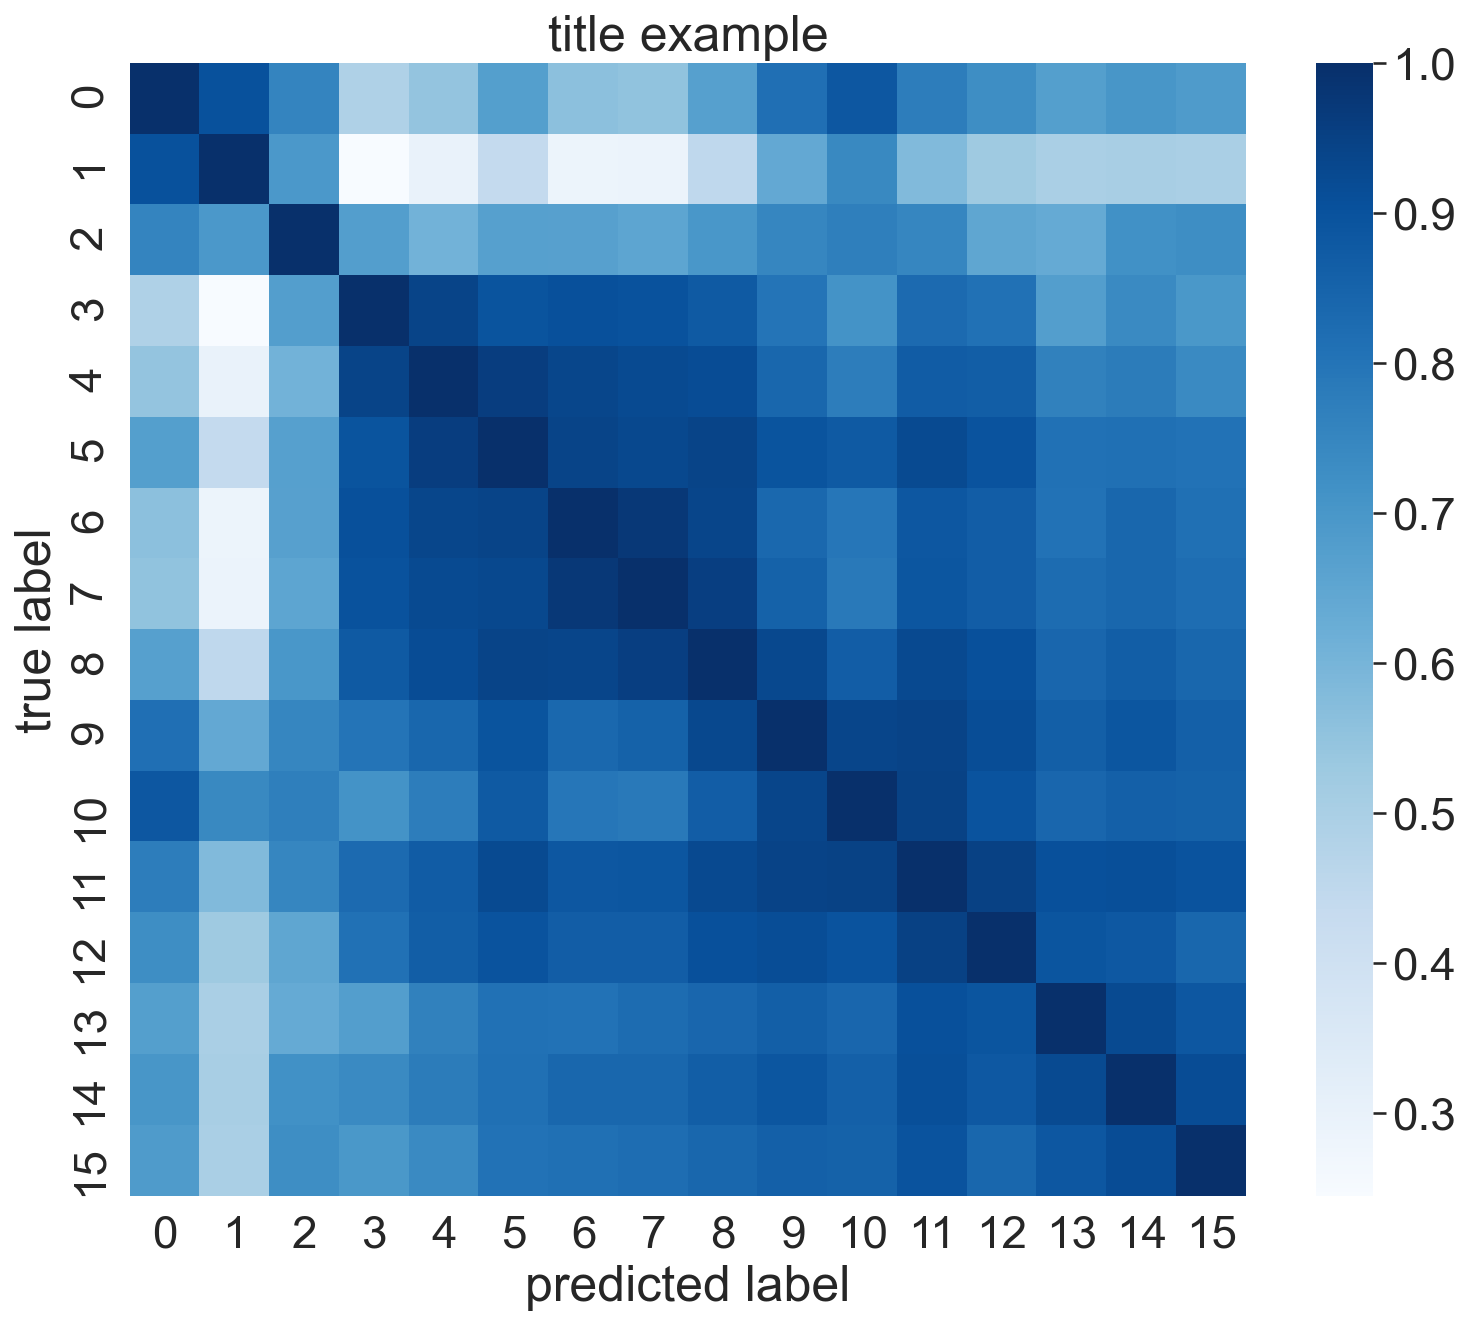

In [25]:
import numpy as np
import seaborn as sns; sns.set_theme()
sns.set(font_scale=2)

def plot_matrix(cm, classes, title):
  plt.figure(figsize=(12,10), dpi=150)
  ax = sns.heatmap(cm, cmap="Blues", annot=False, xticklabels=classes, yticklabels=classes, cbar=True)
  ax.set(title=title, xlabel="predicted label", ylabel="true label")

classes = np.arange(16)
title = "title example"

plot_matrix(evol_confusion_matrix, classes, title)

## dsPCA

In [40]:
# fetch independent variables
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable
                    & keys2trials_all
                    & {'model_id': 10})

# fetch independent variables?
df = util._get_unit_independent_variable(keys2units[0], model_id=10)
df

trial  subject_id  session  model_id left_ right_ contra_  ipsi_  \
0        1      473361       50        10  left  right    left  right   
1        2      473361       50        10  left  right    left  right   
2        3      473361       50        10  left  right    left  right   
3        4      473361       50        10  left  right    left  right   
4        6      473361       50        10  left  right    left  right   
..     ...         ...      ...       ...   ...    ...     ...    ...   
267    382      473361       50        10  left  right    left  right   
268    383      473361       50        10  left  right    left  right   
269    384      473361       50        10  left  right    left  right   
270    385      473361       50        10  left  right    left  right   
271    386      473361       50        10  left  right    left  right   

     left_action_value  right_action_value  ...  ipsi_choice_kernel  \
0             0.480016            0.000000  ...                 NaN   
1             0.729617            0.000000  ...                 NaN   
2             0.859405            0.000000  ...                 NaN   
3             0.446877            0.000000  ...                 NaN   
4             0.712385            0.000000  ...                 NaN   
..                 ...                 ...  ...                 ...   
267           0.001339            0.739947  ...                 NaN   
268           0.000696            0.864777  ...                 NaN   
269           0.000362            0.449670  ...                 NaN   
270           0.000188            0.233821  ...                 NaN   
271           0.000098            0.121583  ...                 NaN   

     relative_action_value_lr  relative_action_value_ic  total_action_value  \
0                   -0.480016                  0.480016            0.480016   
1                   -0.729617                  0.729617            0.729617   
2                   -0.859405                  0.859405            0.859405   
3                   -0.446877                  0.446877            0.446877   
4                   -0.712385                  0.712385            0.712385   
..                        ...                       ...                 ...   
267                  0.738609                 -0.738609            0.741286   
268                  0.864081                 -0.864081            0.865473   
269                  0.449308                 -0.449308            0.450032   
270                  0.233633                 -0.233633            0.234009   
271                  0.121485                 -0.121485            0.121681   

     choice  choice_lr  choice_ic  outcome  reward       rpe  
0      left          0          1      hit       1       1.0  
1      left          0          1      hit       1  0.519984  
2      left          0          1      hit       1  0.270383  
3      left          0          1     miss       0 -0.859405  
4      left          0          1      hit       1  0.553123  
..      ...        ...        ...      ...     ...       ...  
267   right          1          0      hit       1  0.500117  
268   right          1          0      hit       1  0.260053  
269    left          0          1     miss       0 -0.000696  
270    left          0          1     miss       0 -0.000362  
271    left          0          1     miss       0 -0.000188  

[272 rows x 29 columns]

In [41]:
import pandas as pd
from dspca.dspca import dsPCA
import matplotlib.colors as colors


df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left'].sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right'].sort_values(by=['trial'])


# generate targets matrix for dsPCA
# delta_Q
delta_Q = df_Q_left['action_value'].values - df_Q_right['action_value'].values
print('delta_Q: {}'.format(delta_Q.shape))

# sigma_Q
sigma_Q = df_Q_left['action_value'].values + df_Q_right['action_value'].values
print('sigma_Q: {}'.format(sigma_Q.shape))

# choice_Q
trials_all.fetch('water_port').shape
left_trial_ind = np.where(trials_all.fetch('water_port')=='left')
right_trial_ind = np.where(trials_all.fetch('water_port')=='right')

left_trial_indicator = np.zeros_like(trials_all.fetch('water_port'))
left_trial_indicator[left_trial_ind] = 1
right_trial_indicator = np.zeros_like(trials_all.fetch('water_port'))
right_trial_indicator[right_trial_ind] = 1

left_choice_Q = df_Q_left['action_value'].values * left_trial_indicator
right_choice_Q = df_Q_right['action_value'].values * right_trial_indicator
choice_Q = left_choice_Q + right_choice_Q
print('choice_Q: {}'.format(choice_Q.shape))

delta_Q: (264,)
sigma_Q: (264,)
choice_Q: (264,)


In [42]:
# prepare data matrix for dsPCA
# data ([# of observations] X [# of dimensions to be reduced]) 
# targets ([# of observations] X [# of targets])

# for isi: take only time < 2.5s
time_limit = 2.5
data = pop_psth_all[:, :, np.where(bins < time_limit)[0]]
data = np.average(data, axis=2).transpose()
print('input data shape: {}'.format(data.shape))

targets_list = [delta_Q, sigma_Q, choice_Q]
targets = np.vstack(targets_list).transpose()
print('input targets shape: {}'.format(targets.shape))

# dsPCA
[projection_target_subspace, projection_targetfree_subspace, ax_targets, ax_targetfree, 
 target_subspace_signal, targetfree_subspace_signal, target_subspace_var, targetfree_subspace_var,
 total_var, dot_target_ax] = dsPCA(data=data, targets=targets)

print('target_subspace_var: {}'.format(target_subspace_var))
print('targetfree_subspace_var: {}'.format(targetfree_subspace_var[:10]))
print('projection_target_subspace: {}'.format(projection_target_subspace.shape))
print('projection_targetfree_subspace: {}'.format(projection_targetfree_subspace.shape))
print('ax_targets: {}'.format(ax_targets.shape))
print('ax_targetfree: {}'.format(ax_targetfree.shape))
print('check axis norm: {}'.format(np.linalg.norm(ax_targets[:, 0])))

input data shape: (264, 97)
input targets shape: (264, 3)
target_subspace_var: [274.51161982 404.36032635 353.81595241]
targetfree_subspace_var: [393.71556345 167.95955495  79.46770291  70.03746034  64.28337135
  52.78701925  46.9805044   35.6908944   33.74603603  32.03580234]
projection_target_subspace: (264, 3)
projection_targetfree_subspace: (264, 94)
ax_targets: (97, 3)
ax_targetfree: (97, 94)
check axis norm: 0.9999999999999998


In [43]:
# correlation between axis
targets_name = ['delta_Q', 'sigma_Q', 'choice_Q']
for i in range(3):
    for j in range(3):
        if i < j:
            print('correlation between {} and {} axes: {}'.format(
                targets_name[i], targets_name[j],
                np.inner(ax_targets[:, i], ax_targets[:, j])))

for i in range(3):
    for j in range(3):
        print('correlation between {} and target_free {} axes: {}'.format(
                targets_name[i], j,
                np.inner(ax_targets[:, i], ax_targetfree[:, j])))

correlation between delta_Q and sigma_Q axes: -0.28626483765672384
correlation between delta_Q and choice_Q axes: 0.35435109634084444
correlation between sigma_Q and choice_Q axes: -0.9368082432220486
correlation between delta_Q and target_free 0 axes: 4.132165529885379e-17
correlation between delta_Q and target_free 1 axes: -5.289551349013655e-17
correlation between delta_Q and target_free 2 axes: 6.489797035272998e-17
correlation between sigma_Q and target_free 0 axes: -1.3823577699190182e-16
correlation between sigma_Q and target_free 1 axes: 1.000989655747242e-16
correlation between sigma_Q and target_free 2 axes: 1.3032448926454665e-17
correlation between choice_Q and target_free 0 axes: 1.3370923292177483e-16
correlation between choice_Q and target_free 1 axes: -9.725293487194975e-17
correlation between choice_Q and target_free 2 axes: -4.791834789207028e-17


In [44]:
def get_dspca_axis_projection(pop_psth, coding_axis):
    proj = np.inner(np.moveaxis(pop_psth, 0, -1), coding_axis)
    proj_avg = np.average(proj, axis=0)
    proj_std = np.std(proj, axis=0)
    proj_sem = proj_std / np.sqrt(proj.shape[0])

    return proj_avg, proj_sem


def get_psth_by_target_5_division(target_value_arr):
    # get 5 division of psth

    target_hist = plt.hist(target_value_arr, bins=5, cumulative=True)
    sorted_ind_by_target = np.argsort(target_value_arr)
    print(sorted_ind_by_target.shape)

    pop_psth_target_5_div = []
    for i in range(target_hist[0].shape[0]):
        if i == 0:
            print(0, int(target_hist[0][i]))
            pop_psth_target_5_div.append(pop_psth_all[:, sorted_ind_by_target[:int(target_hist[0][i])], :])
        else:
            print(int(target_hist[0][i-1]), int(target_hist[0][i]))
            pop_psth_target_5_div.append(pop_psth_all[:, sorted_ind_by_target[int(target_hist[0][i-1]):int(target_hist[0][i])], :])

    print(pop_psth_target_5_div[0].shape)

    return target_hist, pop_psth_target_5_div


def plot_proj_on_axis_by_target_5_division(pop_psth_target_5_div, ax_targets, target_hist, target='delta_Q', axis='delta_Q'):
    
    axis_table = {'delta_Q': 0, 'sigma_Q': 1, 'choice_Q': 2}
    fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
    for i, c in zip(range(5), colors.TABLEAU_COLORS):
        proj_avg, proj_sem = get_dspca_axis_projection(pop_psth_target_5_div[i], ax_targets[:, axis_table[axis]])
        plt.plot(bins, proj_avg, c=c, label='{} ({:.2f}, {:.2f}): n={}'.format(target, target_hist[1][i], target_hist[1][i+1], 
                                                                               int(target_hist[0][i] - target_hist[0][i-1] if i > 0 else target_hist[0][i])))
        plt.fill_between(bins, proj_avg-proj_sem, proj_avg+proj_sem,
                        alpha=0.5, color=c)
    plt.title('Projection of population psth onto {} axis, grouped by {}'.format(axis, target))
    plt.xlabel('Time (s)')
    plt.ylabel('Projection (a.u.)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    plt.show()


(264,)
0 26
26 71
71 140
140 205
205 264
(97, 26, 324)


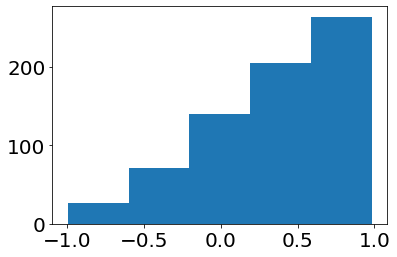

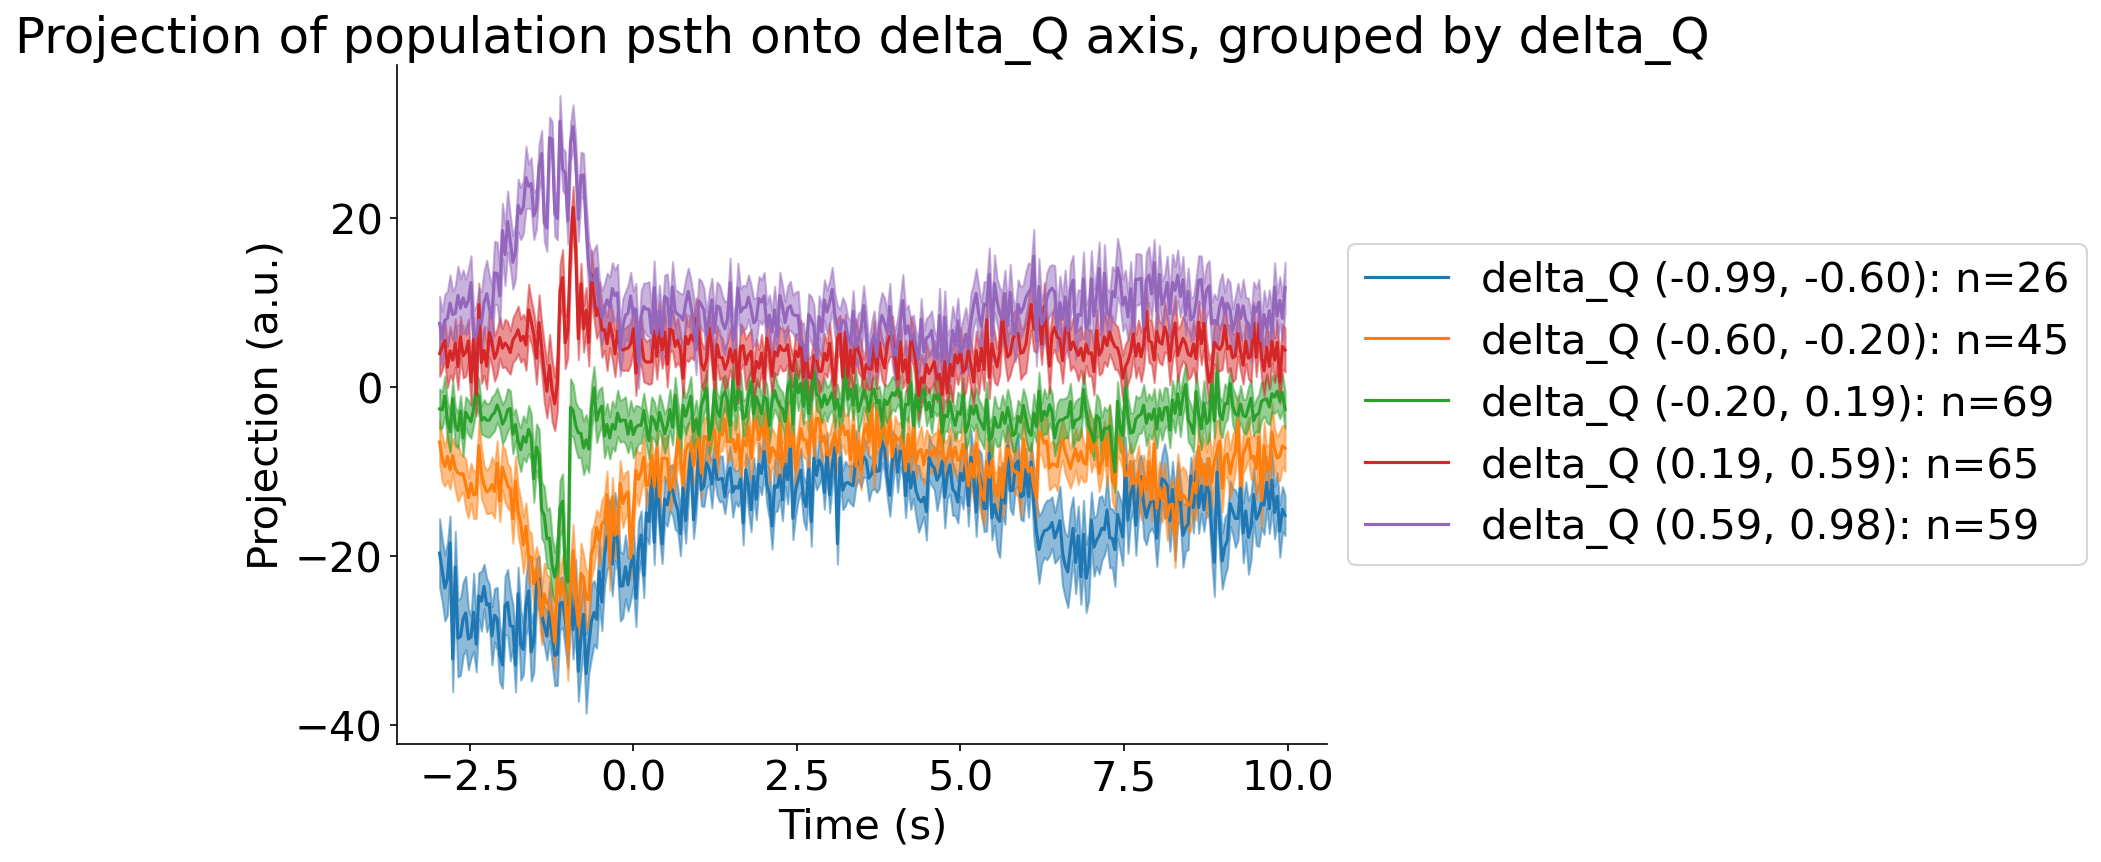

(264,)
0 57
57 108
108 164
164 217
217 264
(97, 57, 324)


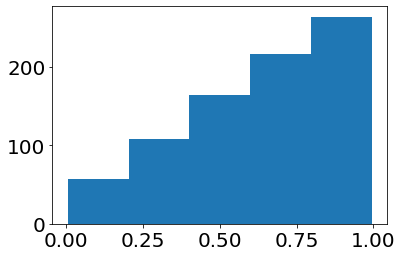

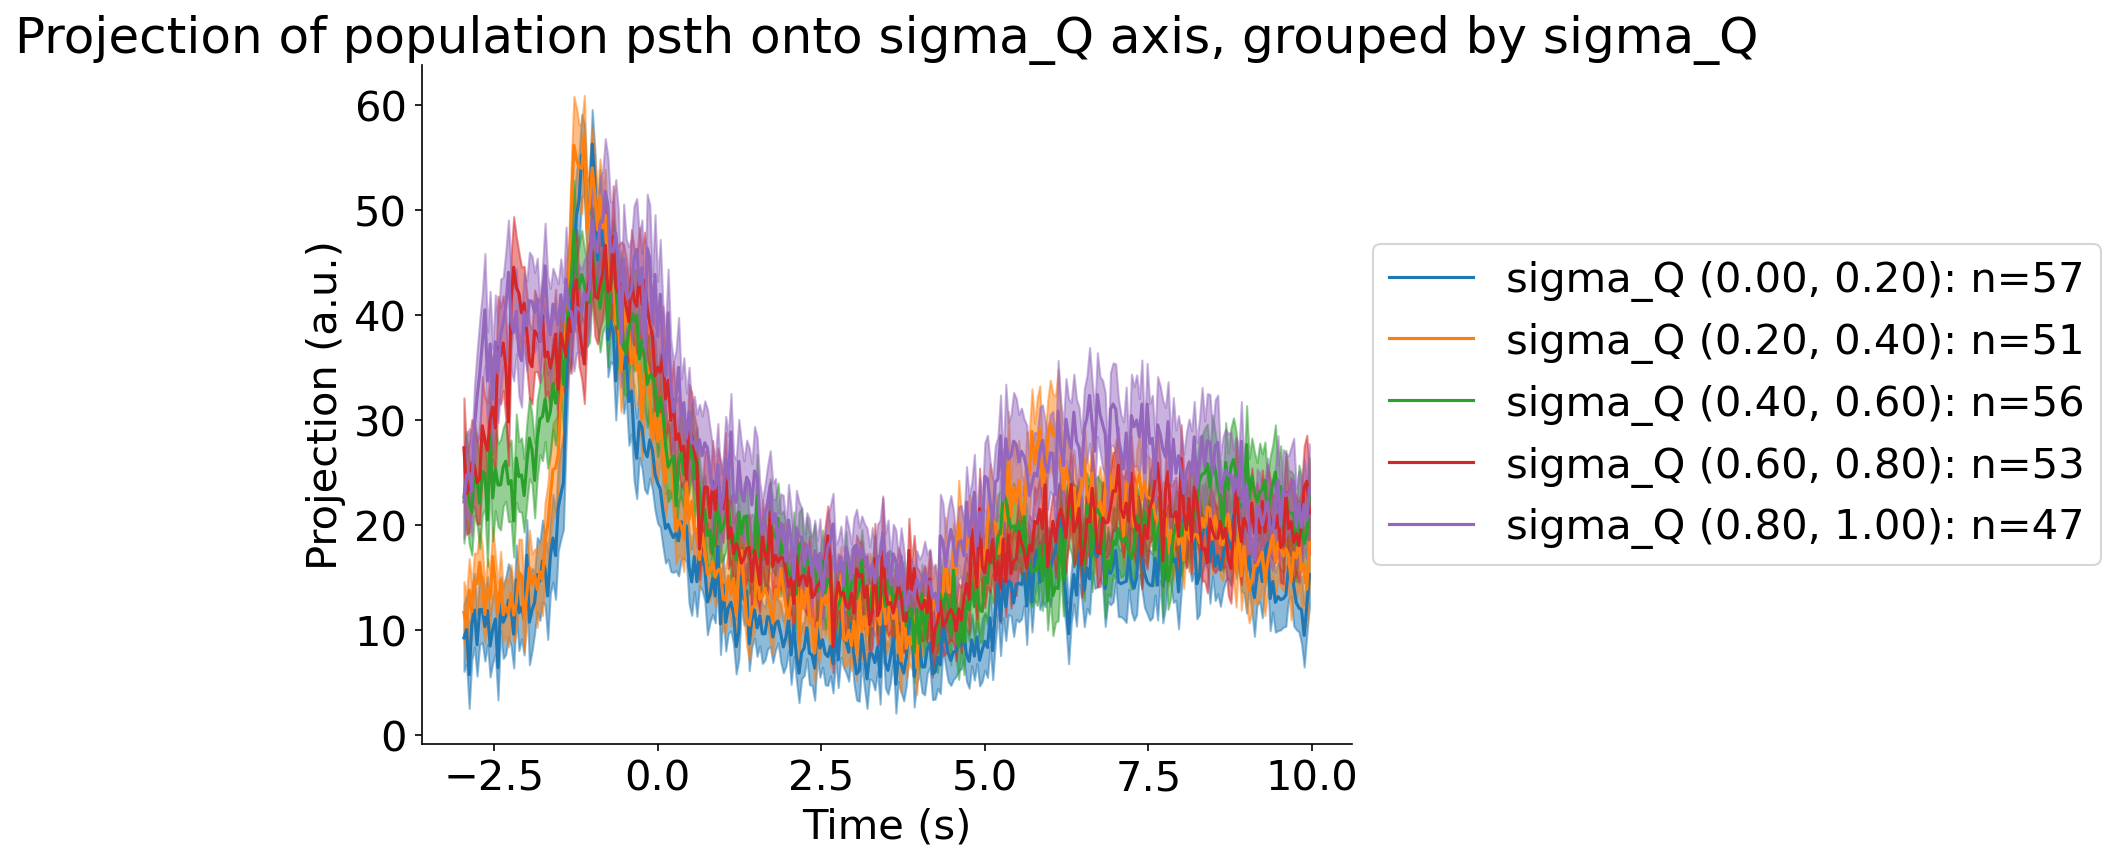

(264,)
0 68
68 114
114 177
177 226
226 264
(97, 68, 324)


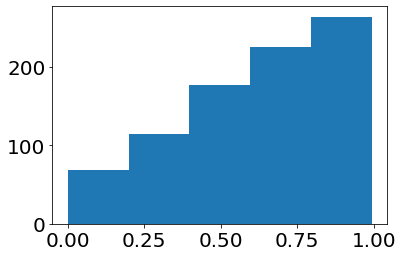

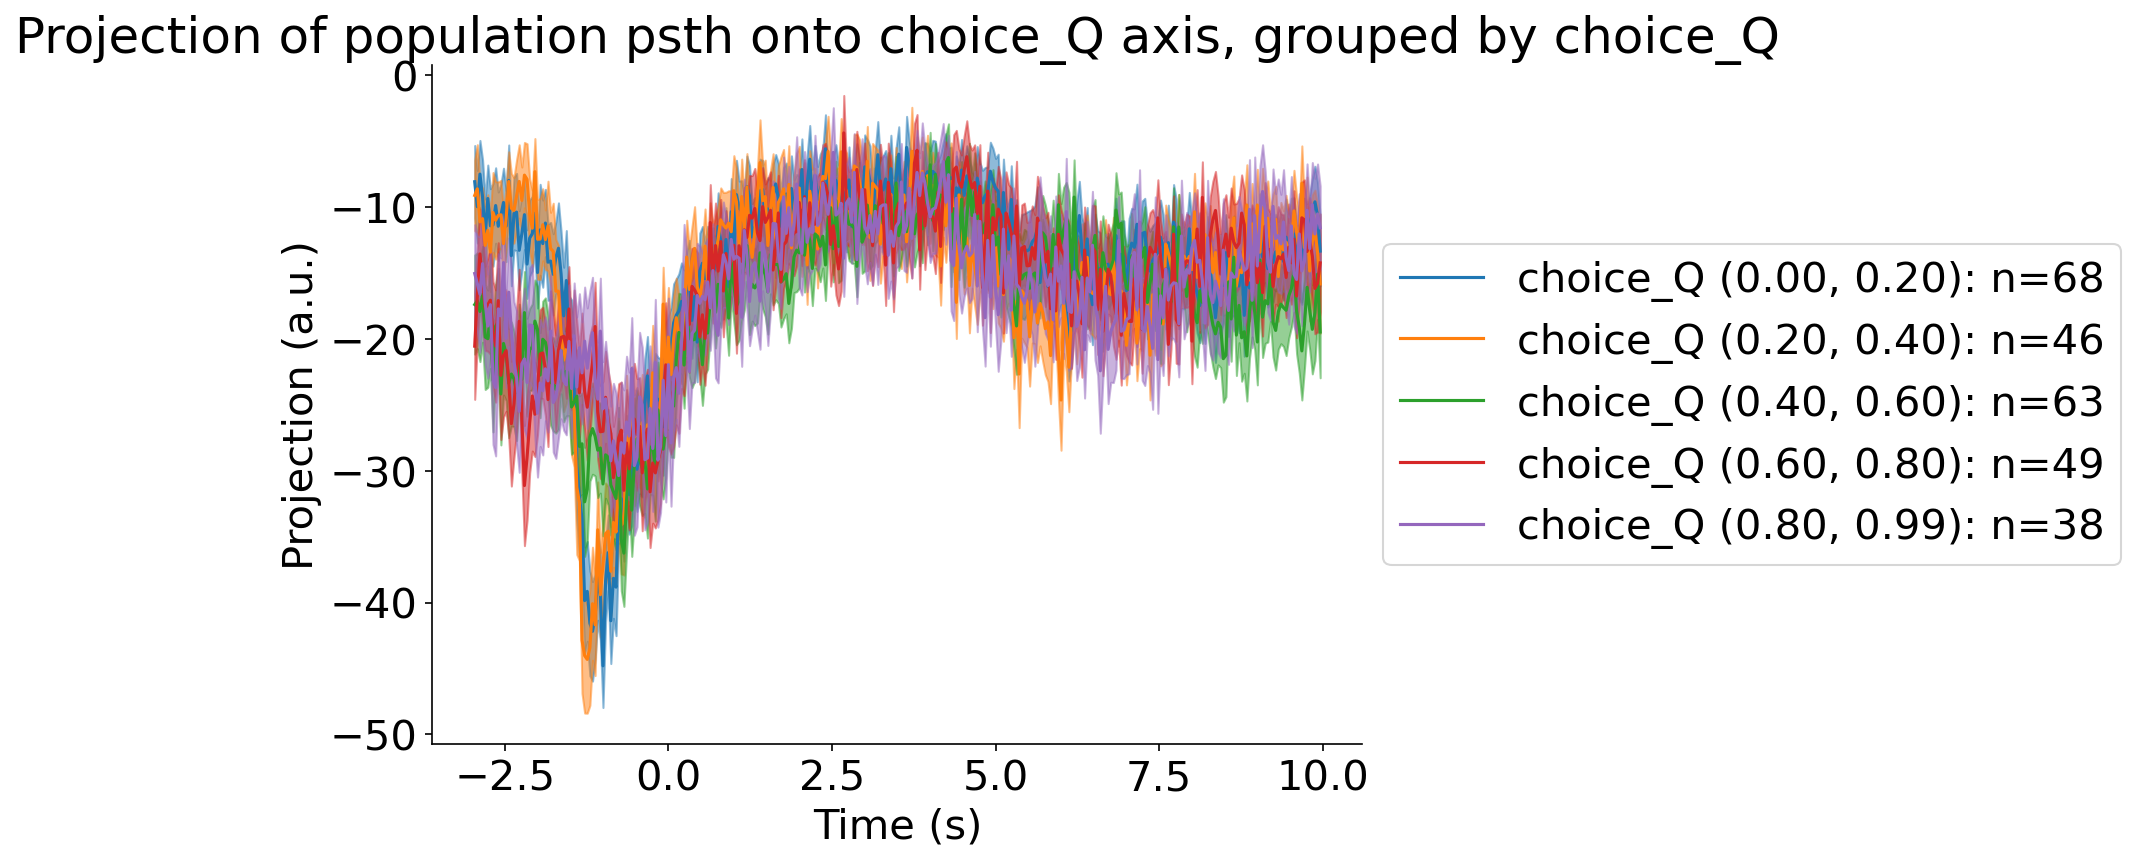

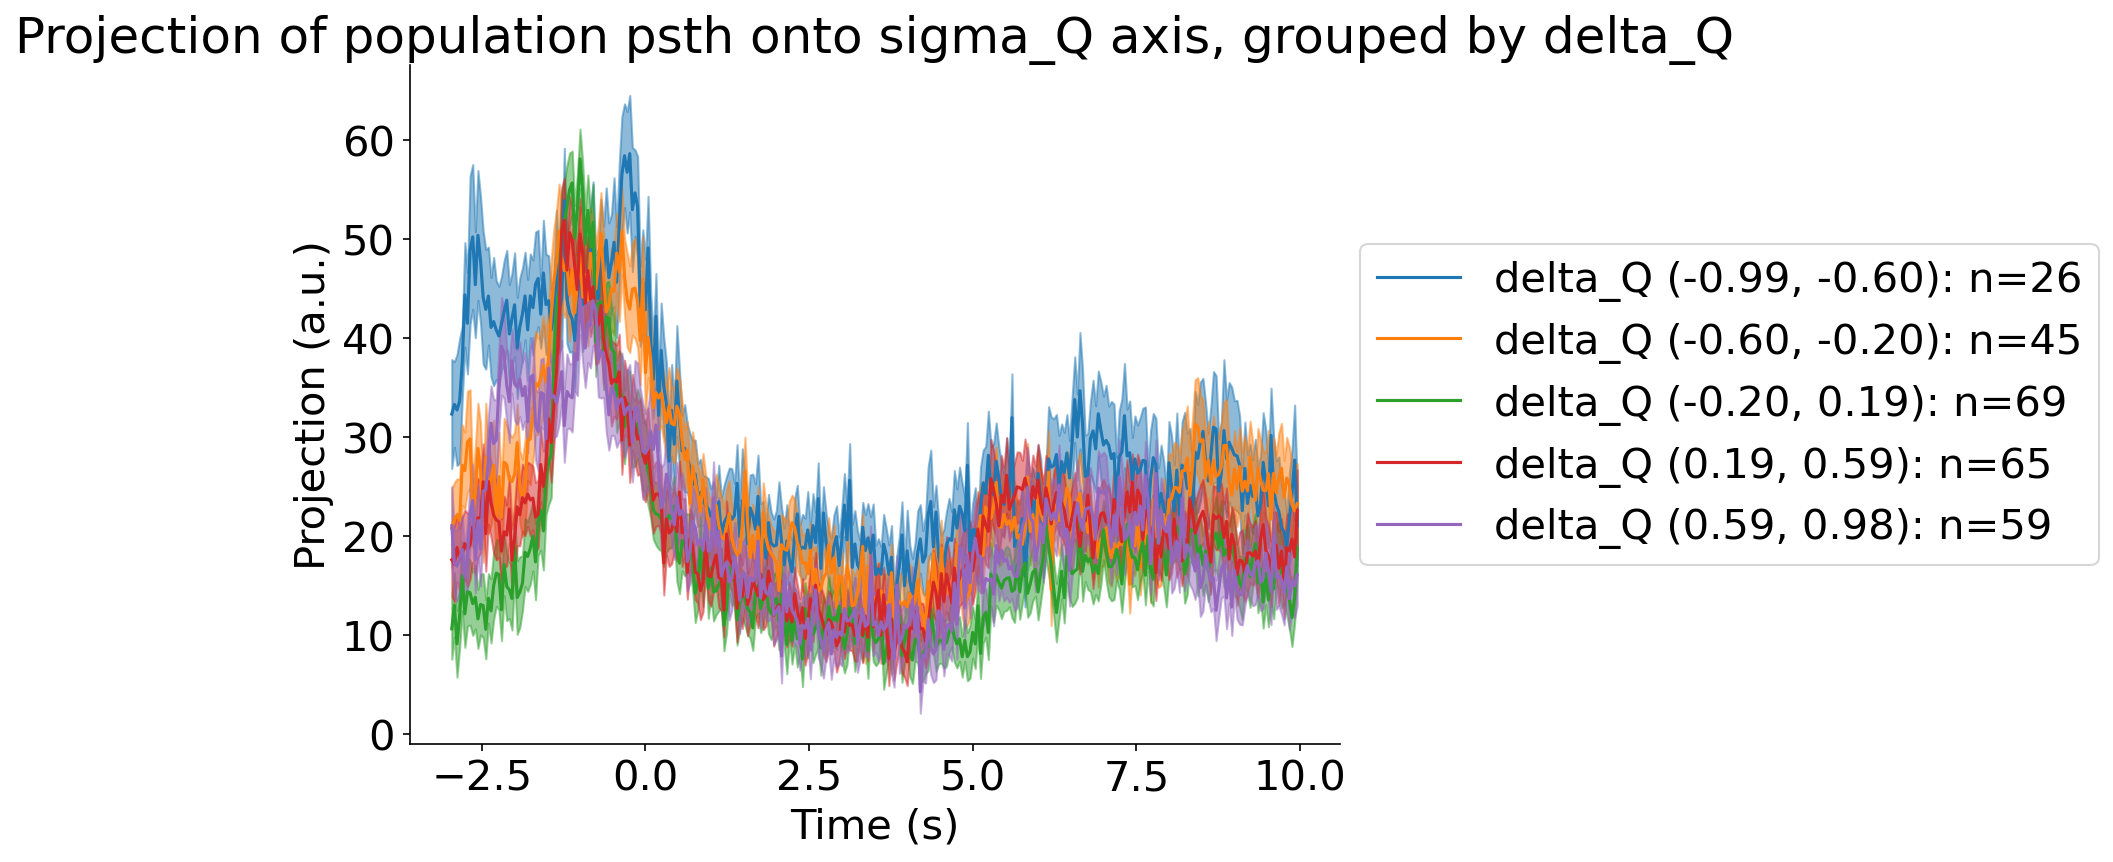

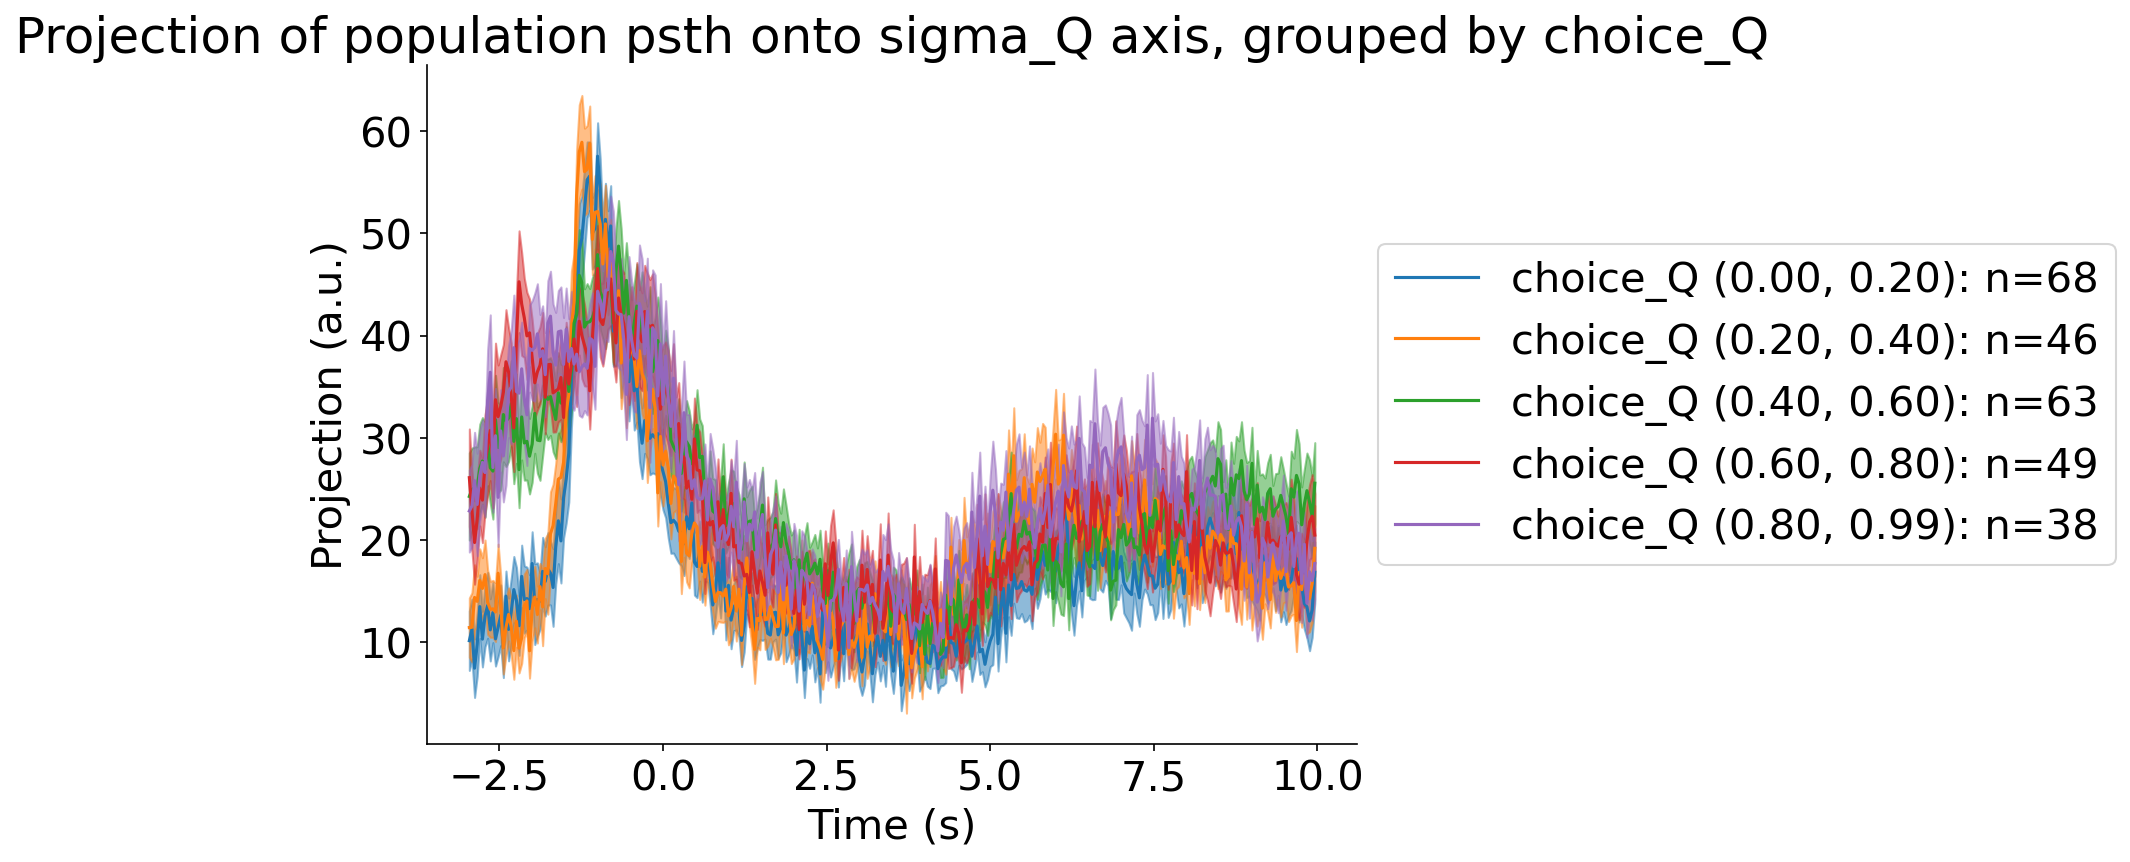

In [45]:
delta_Q_hist, pop_psth_delta_Q_5_div = get_psth_by_target_5_division(delta_Q)
plot_proj_on_axis_by_target_5_division(pop_psth_delta_Q_5_div, ax_targets, delta_Q_hist, 'delta_Q', 'delta_Q')

sigma_Q_hist, pop_psth_sigma_Q_5_div = get_psth_by_target_5_division(sigma_Q)
plot_proj_on_axis_by_target_5_division(pop_psth_sigma_Q_5_div, ax_targets, sigma_Q_hist, 'sigma_Q', 'sigma_Q')

choice_Q_hist, pop_psth_choice_Q_5_div = get_psth_by_target_5_division(choice_Q)
plot_proj_on_axis_by_target_5_division(pop_psth_choice_Q_5_div, ax_targets, choice_Q_hist, 'choice_Q', 'choice_Q')

plot_proj_on_axis_by_target_5_division(pop_psth_delta_Q_5_div, ax_targets, delta_Q_hist, 'delta_Q', 'sigma_Q')
plot_proj_on_axis_by_target_5_division(pop_psth_choice_Q_5_div, ax_targets, choice_Q_hist, 'choice_Q', 'sigma_Q')

In [ ]:
# deprecated
# naive, grouped analysis
proj_avg, proj_sem = get_dspca_axis_projection(pop_psth_all, ax_targets[:, 0])

fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
plt.plot(bins, proj_avg, 'b-')
plt.fill_between(bins, proj_avg-proj_sem, proj_avg+proj_sem,
                alpha=0.5, color='b')
# plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
plt.xlabel('Time (s)')
plt.ylabel('Projection (a.u.)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
plt.show()

In [30]:
# deprecated
# quantile analysis

# get quan
sorted_ind_delta_Q = np.argsort(delta_Q)
print(sorted_ind_delta_Q.shape)

n_quantile = int(delta_Q.shape[0]/ 5)
pop_psth_delta_Q_low20 = pop_psth_all[:, sorted_ind_delta_Q[:n_quantile], :]
pop_psth_delta_Q_top20 = pop_psth_all[:, sorted_ind_delta_Q[n_quantile*(-1):], :]

proj_avg_low20, proj_sem_low20 = get_dspca_axis_projection(pop_psth_delta_Q_low20, ax_targets[:, 0])
proj_avg_top20, proj_sem_top20 = get_dspca_axis_projection(pop_psth_delta_Q_top20, ax_targets[:, 0])

fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
plt.plot(bins, proj_avg_low20, 'b-', label='low delta Q')
plt.fill_between(bins, proj_avg_low20-proj_sem_low20, proj_avg_low20+proj_sem_low20,
                alpha=0.5, color='b')
plt.plot(bins, proj_avg_top20, 'r-', label='high delta Q')
plt.fill_between(bins, proj_avg_top20-proj_sem_top20, proj_avg_top20+proj_sem_top20,
                alpha=0.5, color='r')
# plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
plt.xlabel('Time (s)')
plt.ylabel('Projection (a.u.)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
plt.show()

(408,)


## PCA visualization

In [ ]:
pop_psth_counts = np.average(pop_psth_all, axis=2)

No handles with labels found to put in legend.


[[ 9.91922651e-02  6.67590701e-02  1.62356788e-01 -2.06675148e-01
  -1.44192476e-01 -1.42977177e-01 -3.76197543e-02 -1.24992482e-01
  -4.97484127e-03  2.90411087e-02 -1.45895118e-01  9.54382430e-03
  -7.87630374e-02  2.02146320e-01  3.88571077e-01 -1.26234298e-01
  -4.08270997e-02 -7.02512620e-02  1.06649916e-01 -1.20139437e-01
   6.65525206e-02  2.87402631e-02 -2.85760969e-02 -1.97811503e-01
  -2.49154400e-01  1.55026274e-01 -5.69234943e-02 -9.74524489e-02
   8.05724985e-02  2.59719845e-02  3.27179501e-01 -4.86626231e-02
  -2.00446874e-01  3.03927854e-03 -4.13067144e-02 -1.79707430e-03
  -2.26399539e-02 -1.84327198e-01 -3.38039070e-02 -1.12433622e-01
   3.28827545e-02 -1.56772400e-01 -3.23085860e-01  1.20736865e-02
   1.45455367e-01  1.48192179e-01  8.83799148e-02  8.79146454e-02
   9.38200627e-02 -1.12275881e-01 -1.14359194e-01 -8.27058549e-02
  -4.19705843e-02 -1.36743827e-03 -3.14669974e-03 -3.86185516e-02
  -2.25915414e-02 -7.04539959e-02]
 [-5.24726437e-03 -1.14827765e-03  6.8769

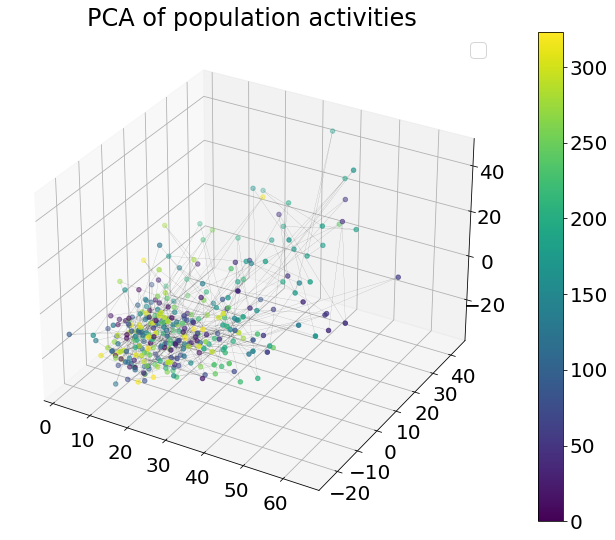

No handles with labels found to put in legend.


[[ 9.91922651e-02  6.67590701e-02  1.62356788e-01 -2.06675148e-01
  -1.44192476e-01 -1.42977177e-01 -3.76197543e-02 -1.24992482e-01
  -4.97484127e-03  2.90411087e-02 -1.45895118e-01  9.54382430e-03
  -7.87630374e-02  2.02146320e-01  3.88571077e-01 -1.26234298e-01
  -4.08270997e-02 -7.02512620e-02  1.06649916e-01 -1.20139437e-01
   6.65525206e-02  2.87402631e-02 -2.85760969e-02 -1.97811503e-01
  -2.49154400e-01  1.55026274e-01 -5.69234943e-02 -9.74524489e-02
   8.05724985e-02  2.59719845e-02  3.27179501e-01 -4.86626231e-02
  -2.00446874e-01  3.03927854e-03 -4.13067144e-02 -1.79707430e-03
  -2.26399539e-02 -1.84327198e-01 -3.38039070e-02 -1.12433622e-01
   3.28827545e-02 -1.56772400e-01 -3.23085860e-01  1.20736865e-02
   1.45455367e-01  1.48192179e-01  8.83799148e-02  8.79146454e-02
   9.38200627e-02 -1.12275881e-01 -1.14359194e-01 -8.27058549e-02
  -4.19705843e-02 -1.36743827e-03 -3.14669974e-03 -3.86185516e-02
  -2.25915414e-02 -7.04539959e-02]
 [-5.24726437e-03 -1.14827765e-03  6.8769

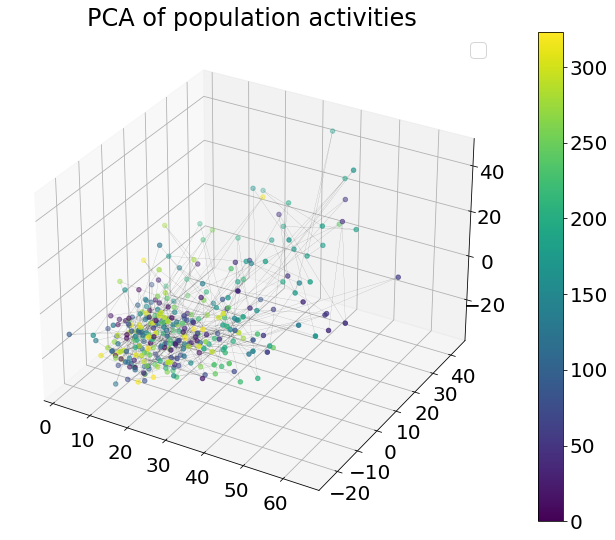

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def pop_counts_pca(pop_psth_avg, cluster_crtieria, verbose=True):
    
    colors = ["navy", "turquoise"]
    lw = 0.01
    
    if cluster_crtieria == 'water_port':
        target_names = ['L', 'R']
        selected_indices = [np.where(np.in1d(all_trial_ind, left_trial_ind))[0],
                            np.where(np.in1d(all_trial_ind, right_trial_ind))[0]]
    elif cluster_crtieria == 'outcome':
        target_names = ['hit', 'miss']
        selected_indices = [np.where(np.in1d(all_trial_ind, hit_trial_ind))[0],
                            np.where(np.in1d(all_trial_ind, miss_trial_ind))[0]]
    else:
        raise ValueError('cluster_criteria ill defined')

    pca = PCA(n_components=3)
    X = pop_psth_avg.transpose()   # (trial, units)
    pca.fit(X)
    print(pca.components_)
    print(pca.explained_variance_)
    X_pca = pca.transform(X)     # (trial, n_feature)

    X_pca_all_time = []
    for i in range(pop_psth_all.shape[2]):
        _X_pca = pca.transform(pop_psth_all[:, :, i].transpose())
        X_pca_all_time.append(_X_pca)
    X_pca_all_time = np.array(X_pca_all_time)

    if verbose:
        print('reduced matrix shape: {}'.format(X_pca_all_time.shape))
        print(X_pca_all_time[:, 0, 0])
        # Percentage of variance explained for each components
        print("explained variance ratio (first two components): %s" % str(pca.explained_variance_ratio_))

    fig = plt.figure(figsize=(15,9))
    ax = fig.add_subplot(111, projection='3d')
    # ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=48, azim=134)
    t = np.arange(X_pca_all_time.shape[0])

    plot_ind = 9
    p = ax.scatter(X_pca_all_time[:, plot_ind, 0], X_pca_all_time[:, plot_ind, 1], X_pca_all_time[:, plot_ind, 2],
                   c=t, cmap='viridis')
    ax.plot(X_pca_all_time[:, plot_ind, 0], X_pca_all_time[:, plot_ind, 1], X_pca_all_time[:, plot_ind, 2],
            'k--', lw=0.1)
    
    # for color, ind, target_name in zip(colors, selected_indices, target_names):
    #     ax.scatter(X_pca_all_time[:, ind, 0], X_pca_all_time[:, ind, 1], X_pca_all_time[:, ind, 2],
    #                color=color, alpha=0.8, lw=lw, label=target_name)
    plt.legend(loc="best")
    fig.colorbar(p)
    plt.title("PCA of population activities")
    plt.show()

pop_counts_pca(pop_psth_counts, 'outcome')
pop_counts_pca(pop_psth_counts, 'water_port')